# CPBC-NN - Country Population By Continent Neural Network (PyTorch)

A minimal PyTorch model to predict continent/region from country population data using a multi-class classification approach.

Dataset
-------
- Kaggle: https://www.kaggle.com/datasets/harshgupta4444/country-population-by-continent

Author
------
- Kevin Thomas: <ket189@pitt.edu>

License
-------
- MIT

In [12]:
# CONFIG — Change these for different datasets
DATA_FILES = {
    'Asia': 'Asian_countries_by_population.csv',
    'Africa': 'African_countries_by_population.csv',
    'Europe': 'Europe_countries_by_population.csv',
    'North America': 'North_American_countries_by_population.csv',
    'South America': 'South_America_countries_by_population.csv',
    'Oceania': 'Oceanian_countries_by_population.csv',
    'Caribbean': 'Caribbean_countries_by_population.csv'
}
TARGET_COL = 'Continent'
TARGET_MAP = None  # will be auto-generated from class labels
MODEL_FILE = 'cpbc_model.pt'
HIDDEN_DIMS = [64, 32]
DROPOUT = 0.3
SEED, BATCH_SIZE, NUM_EPOCHS = 42, 32, 100

## Install, Import, Device & Seed

In [13]:
# Install required packages
%pip install joblib numpy pandas matplotlib seaborn scikit-learn torch

# Imports, device, and seeds
import os
import random, joblib
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
print('DEVICE:', device)

# Set seed for reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print('SEED:', SEED)

Note: you may need to restart the kernel to use updated packages.
DEVICE: cpu
SEED: 42



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load Data

In [14]:
def parse_population(val):
    """
    Parse population value from string to integer.

    This function handles various population string formats including:
    - Comma-separated numbers (e.g., '1,234,567')
    - Quoted strings with commas
    - Non-numeric or missing values (returns NaN)

    Parameters
    ----------
    val : str or numeric
        The population value to parse.

    Returns
    -------
    int or float
        The parsed population as integer, or np.nan if parsing fails.
    """
    if pd.isna(val): return np.nan
    try: return int(str(val).replace(',', '').replace('"', '').strip())
    except: return np.nan


def parse_percentage(val):
    """
    Parse percentage value from string to float.

    This function handles various percentage string formats including:
    - Percent signs (e.g., '2.5%')
    - Negative percentages with minus or unicode minus (e.g., '-0.5%', '−0.5%')
    - Non-numeric or missing values (returns NaN)

    Parameters
    ----------
    val : str or numeric
        The percentage value to parse.

    Returns
    -------
    float
        The parsed percentage as a decimal (e.g., 2.5% becomes 2.5), or np.nan if parsing fails.
    """
    if pd.isna(val): return np.nan
    try: return float(str(val).replace('%', '').replace('−', '-').strip())
    except: return np.nan


def load_and_combine_data(data_files, kaggle_prefix='/kaggle/input/country-population-by-continent'):
    """
    Load and combine multiple CSV files into a single DataFrame with standardized columns.

    This function reads population data from multiple regional CSV files, extracts
    common features (population, growth rate), assigns continent labels, and combines
    them into a unified DataFrame for modeling.

    Parameters
    ----------
    data_files : dict
        A dictionary mapping continent/region names to their corresponding CSV filenames.
        Example: {'Asia': 'Asian_countries_by_population.csv', ...}
    kaggle_prefix : str, default='/kaggle/input/country-population-by-continent'
        The Kaggle input directory prefix. Used when running on Kaggle platform.

    Returns
    -------
    pandas.DataFrame
        A combined DataFrame with columns:
        - Country: country name
        - Population: numeric population value
        - Growth: percentage growth rate
        - Continent: the continent/region label (target variable)
    """
    dfs = []
    for continent, filename in data_files.items():
        filepath = f'{kaggle_prefix}/{filename}' if os.path.exists(kaggle_prefix) else filename
        temp_df = pd.read_csv(filepath)
        # Find population column (varies by file)
        pop_col = [c for c in temp_df.columns if 'population' in c.lower() and 'total' not in c.lower() and '%' not in c.lower()]
        pop_col = pop_col[0] if pop_col else ([c for c in temp_df.columns if 'estimate' in c.lower()] + [None])[0]
        # Find growth column
        growth_col = [c for c in temp_df.columns if 'growth' in c.lower() or 'change' in c.lower()]
        growth_col = growth_col[0] if growth_col else None
        # Find country column
        country_col = [c for c in temp_df.columns if 'country' in c.lower() or 'location' in c.lower()]
        country_col = country_col[0] if country_col else temp_df.columns[0]
        # Build standardized df
        new_df = pd.DataFrame({
            'Country': temp_df[country_col].astype(str).str.replace(r'\[.*\]', '', regex=True).str.strip(),
            'Population': temp_df[pop_col].apply(parse_population) if pop_col else np.nan,
            'Growth': temp_df[growth_col].apply(parse_percentage) if growth_col else np.nan,
            'Continent': continent
        })
        dfs.append(new_df)
    return pd.concat(dfs, ignore_index=True)


# Load data
df = load_and_combine_data(DATA_FILES)
df = df.dropna(subset=['Population'])  # drop rows without population
print(f'Target: {TARGET_COL}\n{df[TARGET_COL].value_counts()}')

Target: Continent
Continent
Africa           57
Europe           56
Asia             53
North America    41
Oceania          28
Caribbean        28
South America    15
Name: count, dtype: int64


## Data Cleaning

In [15]:
# Missing values
print('Missing:\n', df.isnull().sum()[df.isnull().sum() > 0])

Missing:
 Growth    2
dtype: int64


## Exploratory Data Analysis

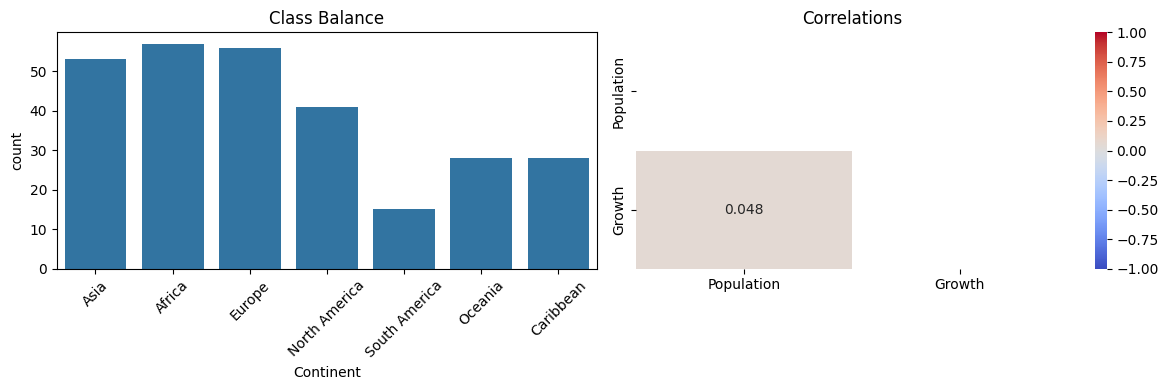

In [16]:
# Class balance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=TARGET_COL, data=df, ax=axes[0]); axes[0].set_title('Class Balance'); axes[0].tick_params(axis='x', rotation=45)

# Correlations
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), cmap='coolwarm', ax=axes[1], vmin=-1, vmax=1, annot=True)
axes[1].set_title('Correlations')
plt.tight_layout(); plt.show()

## Preprocess

In [17]:
def preprocess(df_in, target_col, label_encoder=None, scaler=None, fit=False):
    """
    Preprocess a DataFrame for multi-class classification modeling.

    This function performs the following preprocessing steps:
    1. Encodes the target column using LabelEncoder.
    2. Drops non-numeric columns (like country names).
    3. Adds engineered features (log population, population bins).
    4. Fills missing numeric values with the column median.
    5. Scales numeric features using StandardScaler.

    Parameters
    ----------
    df_in : pandas.DataFrame
        The input DataFrame containing features and target column.
    target_col : str
        The name of the target column to predict.
    label_encoder : sklearn.preprocessing.LabelEncoder, optional
        A pre-fitted LabelEncoder for the target column.
        Required if fit is False.
    scaler : sklearn.preprocessing.StandardScaler, optional
        A pre-fitted StandardScaler to use for transforming features.
        Required if fit is False.
    fit : bool, default=False
        If True, fits new LabelEncoder and StandardScaler on the data.
        If False, uses the provided encoder and scaler for transformation.

    Returns
    -------
    X : pandas.DataFrame
        The preprocessed feature matrix with scaled numeric columns.
    y : numpy.ndarray
        The encoded target values as a 1D array of class indices.
    label_encoder : sklearn.preprocessing.LabelEncoder
        The fitted label encoder (if fit=True) or the input encoder.
    scaler : sklearn.preprocessing.StandardScaler
        The fitted scaler (if fit=True) or the input scaler.
    """
    df = df_in.copy()
    # Encode target
    if fit:
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(df[target_col])
    else:
        y = label_encoder.transform(df[target_col])
    X = df.drop(columns=[target_col, 'Country'])
    # Feature engineering
    X['LogPopulation'] = np.log1p(X['Population'])
    X['PopulationBin'] = pd.qcut(X['Population'], q=5, labels=False, duplicates='drop')
    # Fill missing
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    # Scale
    if fit:
        scaler = StandardScaler()
        X[num_cols] = scaler.fit_transform(X[num_cols])
    else:
        X[num_cols] = scaler.transform(X[num_cols])
    return X, y, label_encoder, scaler


# Preprocess and save artifacts
X_all, y_all, label_encoder, scaler = preprocess(df, TARGET_COL, fit=True)
FEATURE_COLS = X_all.columns.tolist()
NUM_CLASSES = len(label_encoder.classes_)
joblib.dump(scaler, 'cpbc_scaler.joblib'); joblib.dump(FEATURE_COLS, 'cpbc_feature_cols.joblib')
joblib.dump(label_encoder, 'cpbc_label_encoder.joblib')
print(f'Features: {len(FEATURE_COLS)}, Classes: {NUM_CLASSES}')
print(f'Class labels: {list(label_encoder.classes_)}')

Features: 4, Classes: 7
Class labels: ['Africa', 'Asia', 'Caribbean', 'Europe', 'North America', 'Oceania', 'South America']


## Train/Val Split

In [18]:
# Train/val split and DataLoaders
X, y = X_all.values.astype(np.float32), y_all.astype(np.int64)
print(f'Target distribution: {dict(zip(*np.unique(y, return_counts=True)))}')  # debug
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)), batch_size=BATCH_SIZE)
print(f'Train: {len(train_loader)} batches, Val: {len(val_loader)} batches')

Target distribution: {np.int64(0): np.int64(57), np.int64(1): np.int64(53), np.int64(2): np.int64(28), np.int64(3): np.int64(56), np.int64(4): np.int64(41), np.int64(5): np.int64(28), np.int64(6): np.int64(15)}
Train: 7 batches, Val: 2 batches


## Initialize Model & Optimizer

In [19]:
# If model file exists, remove it
if os.path.exists(MODEL_FILE): os.remove(MODEL_FILE)  # clear old weights


class NeuralNetwork(nn.Module):
    """
    A fully connected neural network for multi-class classification.

    This model consists of a sequence of fully connected layers with ReLU activations
    and dropout regularization, followed by a final linear layer that outputs logits
    for each class.

    Architecture
    ------------
    For each hidden dimension in hidden_dims:
        Linear -> ReLU -> Dropout
    Final layer:
        Linear -> num_classes outputs (logits)

    Attributes
    ----------
    net : torch.nn.Sequential
        The sequential container holding all layers of the network.

    Examples
    --------
    >>> model = NeuralNetwork(input_dim=4, num_classes=7, hidden_dims=[64, 32], dropout=0.3)
    >>> x = torch.randn(32, 4)  # batch of 32 samples, 4 features
    >>> logits = model(x)  # shape: (32, 7)
    """

    def __init__(self, input_dim, num_classes, hidden_dims=HIDDEN_DIMS, dropout=DROPOUT):
        """
        Initialize the NeuralNetwork.

        Parameters
        ----------
        input_dim : int
            The number of input features.
        num_classes : int
            The number of output classes for classification.
        hidden_dims : list of int, default=HIDDEN_DIMS
            A list specifying the number of units in each hidden layer.
            For example, [64, 32] creates two hidden layers with 64 and 32 units.
        dropout : float, default=DROPOUT
            The dropout probability applied after each hidden layer.
            Must be between 0 and 1.
        """
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers += [nn.Linear(input_dim, h), nn.ReLU(), nn.Dropout(dropout)]
            input_dim = h
        layers.append(nn.Linear(input_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        """
        Perform a forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, input_dim).

        Returns
        -------
        torch.Tensor
            Output logits of shape (batch_size, num_classes). These are raw scores before
            softmax activation. Use torch.softmax() to convert to probabilities.
        """
        return self.net(x)


# Initialize model and optimizer
model = NeuralNetwork(X_train.shape[1], NUM_CLASSES).to(device)
criterion, optimizer = nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=7, bias=True)
  )
)


## Train Model

In [20]:
# Training loop with early stopping
best_loss, patience, patience_ctr = np.inf, 10, 0
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = np.mean([
        (optimizer.zero_grad(), loss := criterion(model(xb.to(device)), yb.to(device)), loss.backward(), optimizer.step(), loss.item())[-1]
        for xb, yb in train_loader
    ])
    model.eval()
    with torch.no_grad():
        val_loss = np.mean([criterion(model(xb.to(device)), yb.to(device)).item() for xb, yb in val_loader])
    if val_loss < best_loss:
        best_loss, patience_ctr = val_loss, 0
        torch.save(model.state_dict(), MODEL_FILE)
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print(f'Early stop @ epoch {epoch}'); break
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f}')

Epoch 1: train=1.9731 val=1.9471
Epoch 10: train=1.6656 val=1.6387
Epoch 20: train=1.4363 val=1.5403
Epoch 30: train=1.4198 val=1.5581
Early stop @ epoch 32


## Load Model

In [21]:
# Load best model weights
model.load_state_dict(torch.load(MODEL_FILE, map_location=device))
print(f'Training complete. Best val_loss: {best_loss:.4f}')

Training complete. Best val_loss: 1.5387


## Inference

In [22]:
def predict_proba(model, scaler, label_encoder, X, feature_cols, device=device):
    """
    Perform inference on new data using a trained model.

    This function preprocesses the input data by:
    1. Converting to DataFrame format if necessary.
    2. Reindexing to match expected feature columns (filling missing with 0).
    3. Filling any NaN values with the column median.
    4. Scaling features using the provided scaler.
    5. Running inference through the model to get probabilities and predictions.

    Parameters
    ----------
    model : NeuralNetwork
        The trained PyTorch model in evaluation mode.
    scaler : sklearn.preprocessing.StandardScaler
        The fitted scaler used during training to transform features.
    label_encoder : sklearn.preprocessing.LabelEncoder
        The fitted label encoder to decode class predictions.
    X : pandas.DataFrame or numpy.ndarray
        The input features to predict on. If ndarray, must have columns
        matching the order of feature_cols.
    feature_cols : list of str
        The list of feature column names expected by the model,
        in the correct order.
    device : torch.device, default=device
        The device (CPU/GPU) to run inference on.

    Returns
    -------
    probs : numpy.ndarray
        Predicted probabilities for each class, shape (n_samples, n_classes).
        Values are between 0 and 1, summing to 1 per row.
    preds : numpy.ndarray
        Predicted class indices, shape (n_samples,).
    pred_labels : numpy.ndarray
        Predicted class labels (decoded), shape (n_samples,).

    Examples
    --------
    >>> probs, preds, labels = predict_proba(model, scaler, label_encoder, X_test, FEATURE_COLS)
    >>> print(f'Prediction: {labels[0]}, Confidence: {probs[0].max():.3f}')
    """
    x = pd.DataFrame(X, columns=feature_cols) if not isinstance(X, pd.DataFrame) else X.copy()
    x = x.reindex(columns=feature_cols, fill_value=0)
    x = x.fillna(x.median())
    x[feature_cols] = scaler.transform(x[feature_cols])
    with torch.no_grad():
        logits = model(torch.from_numpy(x.values.astype(np.float32)).to(device))
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)
    pred_labels = label_encoder.inverse_transform(preds)
    return probs, preds, pred_labels


# Test with already-scaled X_val
model.eval()
with torch.no_grad():
    logits = model(torch.from_numpy(X_val).to(device))
    probs = torch.softmax(logits, dim=1).cpu().numpy()
preds = probs.argmax(axis=1)
accuracy = (preds == y_val).mean()
print(f'Validation Accuracy: {accuracy:.1%}\n')
print('Sample predictions (first 10):')
for i in range(min(10, len(y_val))):
    actual = label_encoder.inverse_transform([y_val[i]])[0]
    predicted = label_encoder.inverse_transform([preds[i]])[0]
    confidence = probs[i].max()
    match = '✓' if y_val[i] == preds[i] else '✗'
    print(f'  {i+1}. conf={confidence:.3f} → {predicted:15s} (actual: {actual:15s}) {match}')

Validation Accuracy: 32.1%

Sample predictions (first 10):
  1. conf=0.415 → Africa          (actual: Asia           ) ✗
  2. conf=0.382 → Asia            (actual: Africa         ) ✗
  3. conf=0.324 → North America   (actual: North America  ) ✓
  4. conf=0.424 → Europe          (actual: Asia           ) ✗
  5. conf=0.425 → Europe          (actual: Caribbean      ) ✗
  6. conf=0.324 → North America   (actual: Oceania        ) ✗
  7. conf=0.306 → Europe          (actual: North America  ) ✗
  8. conf=0.587 → Europe          (actual: Europe         ) ✓
  9. conf=0.324 → Africa          (actual: Asia           ) ✗
  10. conf=0.335 → North America   (actual: North America  ) ✓
